In [1]:
import gzip

import pandas
import numpy
import matplotlib.pyplot as plt
import seaborn
import IPython

%matplotlib inline

IPython code to download GTEx files (set as markdown to avoid executing):
```python
# Retrieve data from GTEx Download
annotations_url = 'http://www.gtexportal.org/static/datasets/gtex_analysis_v4/annotations/GTEx_Data_V4_Annotations_SampleAttributesDS.txt'
expression_url = 'http://www.gtexportal.org/static/datasets/gtex_analysis_v4/rna_seq_data/GTEx_Analysis_V4_RNA-seq_RNA-SeQCv1.1.8_gene_rpkm.gct.gz'
for url in annotations_url, expression_url:
    !wget --timestamping --directory-prefix download $url
```

In [2]:
# Read sample annotations
path = 'download/GTEx_Data_V4_Annotations_SampleAttributesDS.txt'
sample_df = pandas.read_table(path)

In [3]:
# Collapse samples by tissues
tissue_df = sample_df.groupby(['SMTS', 'SMTSD']).apply(
    lambda df: pandas.Series({'count': len(df)})).reset_index()
#tissue_df.to_csv('data/tissues.tsv', index=False, sep='\t')
tissue_df.head()

,SMTS,SMTSD,count
0,Adipose Tissue,Adipose - Subcutaneous,178
1,Adipose Tissue,Adipose - Visceral (Omentum),31
2,Adrenal Gland,Adrenal Gland,57
3,Bladder,Bladder,11
4,Blood,Cells - EBV-transformed lymphocytes,61


In [4]:
# Read expression matrix
path = 'download/GTEx_Analysis_V4_RNA-seq_RNA-SeQCv1.1.8_gene_rpkm.gct.gz'
rpkm_df = pandas.read_table(path, compression='gzip', skiprows=2)
expr_samples = list(rpkm_df.columns[2:])

# remove version information from the Ensembl identifiers
rpkm_df.insert(0, 'ensembl', rpkm_df.Name.map(lambda x: x.split('.')[0]))
len(rpkm_df)

55993

In [5]:
# Read Entrez Gene Table
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/genes-human.tsv'
entrez_df = pandas.read_table(url)
coding_genes = set(entrez_df.GeneID[entrez_df.type_of_gene == 'protein-coding'])

# Merge with entrez gene identifiers
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/xrefs-human.tsv'
entrez_map_df = pandas.read_table(url)
entrez_map_df = entrez_map_df[entrez_map_df.resource == 'Ensembl']
entrez_map_df = entrez_map_df[['GeneID', 'identifier']].rename(columns={'identifier': 'ensembl'})
entrez_map_df.head()

rpkm_df = entrez_map_df.merge(rpkm_df)
len(rpkm_df)

21315

In [6]:
# Log-transform expression
log_rpkm_df = numpy.log2(1 + rpkm_df.loc[:, expr_samples])
log_rpkm_df.insert(0, 'GeneID', rpkm_df.GeneID)
log_rpkm_df = log_rpkm_df.groupby('GeneID').mean()
log_rpkm_df.head()

,GTEX-N7MS-0007-SM-2D7W1,GTEX-N7MS-0008-SM-4E3JI,GTEX-N7MS-0011-R10A-SM-2HMJK,GTEX-N7MS-0011-R11A-SM-2HMJS,GTEX-N7MS-0011-R1a-SM-2HMJG,GTEX-N7MS-0011-R2a-SM-2HML6,GTEX-N7MS-0011-R3a-SM-33HC6,GTEX-N7MS-0011-R4a-SM-2HMKW,GTEX-N7MS-0011-R5a-SM-2HMK8,GTEX-N7MS-0011-R6a-SM-2HMJ4,...,GTEX-XYKS-1626-SM-4BRUQ,GTEX-XYKS-1726-SM-4E3IO,GTEX-XYKS-1826-SM-4E3JV,GTEX-XYKS-2126-SM-4E3IB,GTEX-XYKS-2226-SM-4E3IU,GTEX-XYKS-2426-SM-4AT43,GTEX-XYKS-2526-SM-4BOPX,GTEX-XYKS-2626-SM-4BRUT,GTEX-XYKS-2726-SM-4E3IC,GTEX-Y8E5-0006-SM-47JWQ
GeneID,,,,,,,,,,,,,,,,,,,,,
1,0.311820,1.937881,1.126384,1.992035,1.394212,1.463760,1.010630,1.535261,1.666354,1.835874,...,1.882378,1.163119,1.116207,0.630426,0.936475,0.381998,2.023546,1.453020,1.268611,0.386387
2,1.067622,2.450518,5.441688,4.154868,5.400437,6.336678,5.176390,5.576723,6.134185,5.392008,...,7.501447,5.847878,8.173991,5.774519,6.368695,5.927066,7.161699,9.153686,7.005127,0.429825
3,0.081296,0.000000,0.167481,0.211283,0.310622,0.551256,0.119339,0.344616,0.338547,0.296911,...,0.150900,0.053333,0.237746,0.066271,0.103689,0.106960,0.309323,0.088636,0.250913,0.024326
9,0.167221,1.573928,0.067011,0.237407,0.248602,0.182820,0.289412,0.233890,0.271461,0.184280,...,0.922844,0.767204,1.135666,0.235615,2.183439,0.286435,0.664430,0.337425,0.537202,0.619730
10,0.000000,0.032087,0.032556,0.035982,0.040135,0.000000,0.230931,0.144839,0.195259,0.264529,...,1.077083,0.213125,0.147201,0.000000,2.264924,0.000000,0.144433,0.052697,0.068557,0.000000


In [7]:
# Collapse by tissue type
sample_to_tissue = dict(zip(sample_df.SAMPID, sample_df.SMTSD))
tissue_df = log_rpkm_df.groupby(sample_to_tissue, axis=1).mean()
tissue_df.head()

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
GeneID,,,,,,,,,,,,,,,,,,,,,
1,0.887261,1.149751,0.718482,0.947883,1.732377,1.281334,0.668745,1.449559,1.242630,1.507707,...,0.982397,0.815125,1.244113,2.022638,0.690088,0.743536,1.311534,1.809855,1.617463,0.832418
2,8.053274,8.190426,6.329136,9.097407,8.817140,8.757927,8.367433,5.392608,5.287136,5.653610,...,5.428848,5.732939,6.949578,7.268549,6.611662,5.027820,7.527919,7.765785,6.753959,1.239130
3,0.412301,0.384383,0.389483,0.096346,0.127221,0.088511,0.399046,0.246538,0.206133,0.279888,...,0.104579,0.116251,0.237453,0.578067,0.113419,0.329152,0.181439,0.252814,0.172909,0.072254
9,0.687608,0.968473,0.809096,0.718050,0.819648,0.401177,0.835985,0.197114,0.171115,0.254592,...,0.424773,0.412577,1.593686,1.334143,1.103335,0.909079,0.791403,0.793821,0.733685,0.702577
10,0.041992,0.148011,0.121707,0.060740,0.062321,0.033336,0.059029,0.161499,0.134369,0.343883,...,0.056631,0.026846,2.120257,0.850855,0.051200,0.393592,0.043094,0.475157,0.159574,0.024063


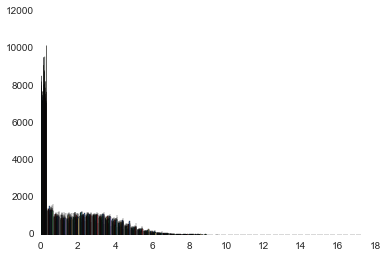

In [8]:
# Histogram of expression values
plt.hist(tissue_df.as_matrix(), bins=50);

In [9]:
# save as tsv
with gzip.open('data/expression-SMTSD.tsv.gz', 'wt') as write_file:
    tissue_df.reset_index().to_csv(write_file, sep='\t', index=False, float_format='%.4f')

In [10]:
# restrict to coding genes
coding_df = tissue_df[tissue_df.index.isin(coding_genes)]
len(coding_df)

16960

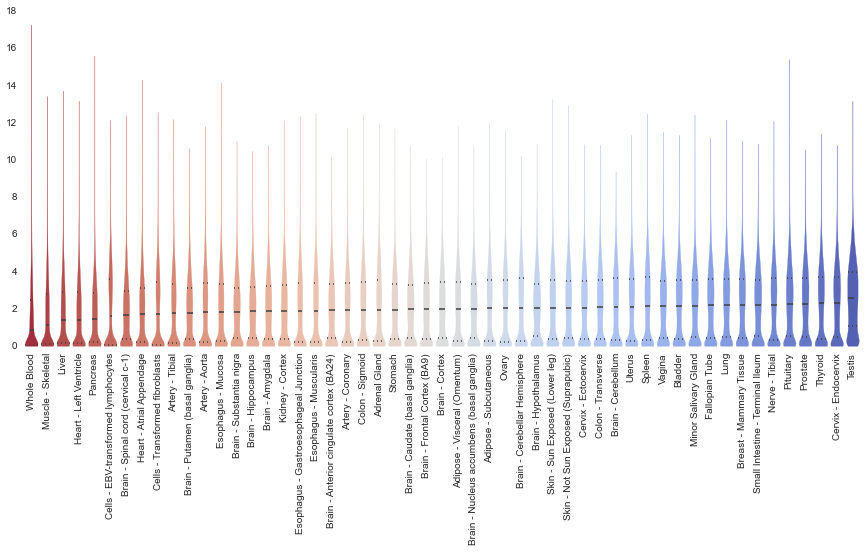

In [15]:
# Plot structure-specific tissue distributions
IPython.core.pylabtools.figsize(15, 6)
medians = coding_df.median().sort(inplace=False)
g = seaborn.violinplot(coding_df, color='coolwarm_r', order=medians.index, lw=0, cut=0);
plt.xticks(rotation='vertical');